In [1]:
import torch
import clip
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

<img src=clip.png>

<a href=https://github.com/openai/CLIP>CLIP torch model usage</a><br>
<a href=https://arxiv.org/pdf/2103.00020.pdf>CLIP paper for deeper understanding</a>

In [3]:
inputs = ["a diagram", "a dog", "a cat"]
image = preprocess(Image.open("clip.png")).unsqueeze(0).to(device)
text = clip.tokenize(inputs).to(device)

In [4]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [5]:
text_features.shape

torch.Size([3, 512])

In [7]:
print("Label probs:", probs)

Label probs: [[0.9927   0.004253 0.003016]]


In [8]:
logits_per_image  # similarity

tensor([[25.5312, 20.0781, 19.7344]], device='cuda:0', dtype=torch.float16)

In [9]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(3)

print("\nTop predictions:")
for value, index in zip(values, indices):
    print(f"{inputs[index]:>5s}: {100 * value.item():.2f}%")
similarity


Top predictions:
a diagram: 100.00%
a cat: 0.00%
a dog: 0.00%


tensor([[1., 0., 0.]], device='cuda:0', dtype=torch.float16)

In [12]:
similarity = np.empty((3, ))
for i in range(3):
    sim = 100.0 * nn.functional.cosine_similarity(image_features, text_features[i])
    similarity[i] = sim

print(inputs[np.argmax(similarity)], similarity)

a diagram [25.53125 20.0625  19.71875]


**Great usage of CLIP model** 
<br><a href=https://cdn.openai.com/papers/dall-e-2.pdf>dalle original paper</a>

<img src=dalle.png width=800 height=300>

### Main script

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os, re, gc

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
stop = stopwords.words('english')

import spacy
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

from transformers import LongformerTokenizerFast, LongformerModel
from transformers import AdamW, get_linear_schedule_with_warmup

seed = 42
gc.enable()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [5]:
def preprocessor(text, stop=stop):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = [w for w in text.split() if w not in stop]
    text = [re.sub(r"[^a-zA-Z0-9]+", '', k) for k in text]
    return re.sub(' +', ' ', ' '.join(text))

def snow_stem(text):
    snow_stemmer = SnowballStemmer(language='english')
    new_text = ''
    for word in text.split():
        new_text += snow_stemmer.stem(word) + ' '
    return new_text

In [6]:
train = pd.read_csv("train.csv")

<AxesSubplot:>

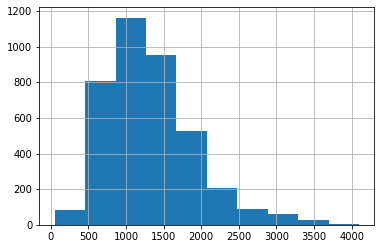

In [16]:
train.full_text.apply(preprocessor).str.len().hist()

**Use CLIP context encoder for feature extraction / alt: use BERT/word2vec encoding for same purpose**

In [ ]:
class ClipDataset(Dataset):
    def __init__(self, data, max_len=None, preprocess=False):
        self.data = data
        if max_len is None:
            self.max_len = model.context_length
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        raw_text = self.data.iloc[ix, 1]
        labels = self.data.iloc[ix, 2:]
        raw_text = raw_text[:self.max_len]
        if self.preprocess:
            raw_text = snow_stem(preprocessor(raw_text))
        
        return raw_text, labels
    
    def _encode(self, text: list):
        text = clip.tokenize(text, context_length=self.max_len).to(device)
        with torch.no_grad():
            text_features = model.encode_text(text)
        return text_features.type(torch.float32)
    
    def collate_fn(self, batch):
        text, labels = list(zip(*batch))
        text = self._encode(text)
        labels = torch.as_tensor([label.values for label in labels], dtype=torch.float32).to(device)
        return text, labels

In [7]:
x_train, x_valid = train_test_split(train, shuffle=True, test_size=0.2, random_state=seed)

In [ ]:
train_ds = ClipDataset(x_train, preprocess=True)
valid_ds = ClipDataset(x_valid, preprocess=True)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, collate_fn=valid_ds.collate_fn)

In [ ]:
class TextModel(nn.Module):
    def __init__(self, short=True):
        super(TextModel, self).__init__()
        if short:
            self.regressor = nn.Sequential(
                                    nn.Dropout(p=0.5),
                                    nn.Linear(512, 6))
        else:
            self.regressor = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Linear(512, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(256, 6)
            )
            
    def forward(self, x):
        return self.regressor(x)

In [ ]:
net = TextModel(short=True).to(device)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.1, patience=5)

In [8]:
def MCRMSE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=1))
    rcrmse = np.mean(rmse)
    return rcrmse

In [ ]:
train_losses, valid_losses = [], []
epochs = 100

for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    
    losses, scores = [], []
    for batch in train_dl:
        net.train()
        optimizer.zero_grad()
        
        text, labels = batch
        logits = net(text)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_train_scores = np.mean(scores)
    epoch_train_loss = np.mean(losses)
    train_losses.append(epoch_train_loss)
    
    losses, scores = [], []
    for batch in valid_dl:
        net.eval()
        text, labels = batch
        
        with torch.no_grad():
            logits = net(text)
            loss = criterion(logits, labels)
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_valid_loss = np.mean(losses)
    epoch_valid_scores = np.mean(scores)
    valid_losses.append(epoch_valid_loss)
    
    scheduler.step(epoch_valid_loss)
    
    print(f"Train loss: {epoch_train_loss:.5f}, valid loss: {epoch_valid_loss:.5f}")
    print(f"Train scores: {epoch_train_scores:.5f}, valid scores: {epoch_valid_scores:.5f}")

In [10]:
test = pd.read_csv("test.csv")

In [ ]:
test_columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
submission = pd.DataFrame(data={"text_id": test.text_id})
submission[test_columns] = 0.0

In [ ]:
test_preds = []

net.eval()
for i in range(len(test)):
    text = test.iloc[i, 1][:model.context_length]
    text = clip.tokenize(text).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text).type(torch.float32).unsqueeze(0)
        output = net(text_features)
    output = output.cpu().detach().numpy().squeeze()
    submission.iloc[i, 1:] = output

In [ ]:
submission

In [ ]:
submission.to_csv("submission.csv", index=False)
!kaggle competitions submit -c feedback-prize-english-language-learning -f submission.csv -m "Message"

## Bert Encoder
<br><a href=https://arxiv.org/pdf/2004.05150.pdf>Longformer original paper</a>

<img src=bert.png width=500 height=300>

In [14]:
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length=4096)
bert = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in tqdm(data):
        encoded_sent = tokenizer(snow_stem(preprocessor(sent)), padding='max_length', truncation=True, max_length=4096)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
train_inputs, train_masks = preprocessing_for_bert(x_train['full_text'].values)
val_inputs, val_masks = preprocessing_for_bert(x_valid['full_text'].values)

  0%|          | 0/3128 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

In [17]:
train_labels = torch.as_tensor(x_train.iloc[: , 2:].values, dtype=torch.float32)
valid_labels = torch.as_tensor(x_valid.iloc[: , 2:].values, dtype=torch.float32)

In [18]:
train_ds = TensorDataset(train_inputs, train_masks, train_labels)
valid_ds = TensorDataset(val_inputs, val_masks, valid_labels)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=False)

In [19]:
class BertModel(nn.Module):
    def __init__(self, mode="short"):
        super(BertModel, self).__init__()
        self.mode = mode
        if mode == "short":
            self.predictor = nn.Sequential(
                                           nn.Dropout(p=0.5),
                                           nn.Linear(768, 6)
                                          )
        elif mode == "long":
            self.predictor = nn.Sequential(
                                           nn.Linear(768, 768),
                                           nn.LeakyReLU(0.01, inplace=True),
                                           nn.Dropout(p=0.5),
                                           nn.Linear(768, 6)
            )
        elif mode == "conv":
            self.predictor = nn.Sequential(
                                           nn.Conv1d(in_channels=4096, out_channels=1024, kernel_size=3, stride=2, padding=0),
                                           nn.LeakyReLU(0.01, inplace=True),
                                           nn.Dropout(p=0.5),
                                           nn.Conv1d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=0),
                                           nn.LeakyReLU(0.01, inplace=True),
                                           nn.Dropout(p=0.5),
                                           nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=2, padding=0),
                                           nn.LeakyReLU(0.01, inplace=True),
                                           nn.Dropout(p=0.5),
                                           nn.AdaptiveAvgPool1d(32),
                                           nn.Flatten(),
                                           nn.Dropout(p=0.5),
                                           nn.Linear(2048, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 6)
                                           
            )
            
    def forward(self, input_ids, attention_masks):
        with torch.no_grad():
            outputs = bert(input_ids=input_ids.to(device), attention_mask=attention_masks.to(device))
            if self.mode == "short" or self.mode == "long":
                hidden = outputs.pooler_output  # outputs[0][:, 0, :] # last layer hidden-state of CLS token
            elif self.mode == "conv":
                hidden = outputs.last_hidden_state  # outputs[0]  # output hidden-states sequence
            else:
                raise ValueError(f"mode is expected to be 'short' or 'long', given {mode}")
        return self.predictor(hidden)

In [20]:
net = BertModel(mode="conv").to(device)

criterion = nn.MSELoss()
epochs = 15
total_steps = total_steps = len(train_dl) * epochs
optimizer = AdamW(net.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=20, num_training_steps=total_steps)

In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    
    losses, scores = [], []
    for batch in tqdm(train_dl, total=len(train_dl), leave=False):
        net.train()
        optimizer.zero_grad()
        
        input_ids, att_masks, labels = batch
        logits = net(input_ids.to(device), att_masks.to(device))
        loss = criterion(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_train_scores = np.mean(scores)
    epoch_train_loss = np.mean(losses)
    train_losses.append(epoch_train_loss)
    
    losses, scores = [], []
    for batch in tqdm(valid_dl, total=len(valid_dl), leave=False):
        net.eval()
        input_ids, att_masks, labels = batch
        
        with torch.no_grad():
            logits = net(input_ids.to(device), att_masks.to(device))
            loss = criterion(logits, labels.to(device))
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_valid_loss = np.mean(losses)
    epoch_valid_scores = np.mean(scores)
    valid_losses.append(epoch_valid_loss)
    
    scheduler.step(epoch_valid_loss)
    
    print(f"Train loss: {epoch_train_loss:.5f}, valid loss: {epoch_valid_loss:.5f}")
    print(f"Train scores: {epoch_train_scores:.5f}, valid scores: {epoch_valid_scores:.5f}")

In [ ]:
# train: short,Train loss: 0.52810, valid loss: 0.47120
#Train scores: 0.65202, valid scores: 0.61893 -> train more
# long, conv.

## DeBERTa
<br><a href=https://arxiv.org/pdf/2111.09543.pdf>DeBERTa v3 original paper</a><br><b>here first deberta used as for conflicts in packages</b>

<img src=deberta.jpg>

In [9]:
from transformers import DebertaTokenizer, DebertaModel

In [10]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaModel.from_pretrained('microsoft/deberta-base', return_dict=True).to(device)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def tokenize_for_deberta(text):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(text):
        encoded_sent = tokenizer(snow_stem(preprocessor(sent)), padding='max_length', truncation=True, max_length=512)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [12]:
train_inputs, train_masks = tokenize_for_deberta(x_train['full_text'].values)
val_inputs, val_masks = tokenize_for_deberta(x_valid['full_text'].values)

train_labels = torch.as_tensor(x_train.iloc[: , 2:].values, dtype=torch.float32)
valid_labels = torch.as_tensor(x_valid.iloc[: , 2:].values, dtype=torch.float32)

  0%|          | 0/3128 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

In [13]:
train_ds = TensorDataset(train_inputs, train_masks, train_labels)
valid_ds = TensorDataset(val_inputs, val_masks, valid_labels)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=False)

In [14]:
class DeBERTaModel(nn.Module):
    def __init__(self):
        super(DeBERTaModel, self).__init__()
        self.predictor = nn.Sequential(
                                       nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=0),
                                       nn.LeakyReLU(0.01, inplace=True),
                                       nn.Dropout(p=0.5),
                                       nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=0),
                                       nn.LeakyReLU(0.01, inplace=True),
                                       nn.Dropout(p=0.5),
                                       nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, stride=2, padding=0),
                                       nn.LeakyReLU(0.01, inplace=True),
                                       nn.Dropout(p=0.5),
                                       nn.AdaptiveAvgPool1d(32),
                                       nn.Flatten(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(2048, 256),
                                       nn.ReLU(),
                                       nn.Linear(256, 6)

        )

    def forward(self, input_ids, attention_masks):
        with torch.no_grad():
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_masks.to(device))
            hidden = outputs.last_hidden_state

        return self.predictor(hidden)
    
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
class FeedBackModel(nn.Module):
    def __init__(self):
        super(FeedBackModel, self).__init__()
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(768, 6)
        
    def forward(self, ids, mask):        
        out = model(input_ids=ids, attention_mask=mask, output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [16]:
net = AttModel().to(device)  # FeedBackModel is most stable

criterion = nn.MSELoss()
epochs = 12
total_steps = total_steps = len(train_dl) * epochs
optimizer = AdamW(net.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=total_steps)

In [17]:
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    
    losses, scores = [], []
    for batch in tqdm(train_dl, total=len(train_dl), leave=False):
        net.train()
        optimizer.zero_grad()
        
        input_ids, att_masks, labels = batch
        logits = net(input_ids.to(device), att_masks.to(device))
        loss = criterion(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_train_scores = np.mean(scores)
    epoch_train_loss = np.mean(losses)
    train_losses.append(epoch_train_loss)
    
    losses, scores = [], []
    for batch in tqdm(valid_dl, total=len(valid_dl), leave=False):
        net.eval()
        input_ids, att_masks, labels = batch
        
        with torch.no_grad():
            logits = net(input_ids.to(device), att_masks.to(device))
            loss = criterion(logits, labels.to(device))
        losses.append(loss.item())
        scores.append(MCRMSE(labels.detach().cpu().numpy(), logits.detach().cpu().numpy()))
    epoch_valid_loss = np.mean(losses)
    epoch_valid_scores = np.mean(scores)
    valid_losses.append(epoch_valid_loss)
    
    scheduler.step(epoch_valid_loss)
    
    print(f"Train loss: {epoch_train_loss:.5f}, valid loss: {epoch_valid_loss:.5f}")
    print(f"Train scores: {epoch_train_scores:.5f}, valid scores: {epoch_valid_scores:.5f}")

Epoch 1 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 12.58959, valid loss: 12.26212
Train scores: 3.49834, valid scores: 3.45859
Epoch 2 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 1.87987, valid loss: 0.45121
Train scores: 1.13322, valid scores: 0.61248
Epoch 3 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.68205, valid loss: 0.44936
Train scores: 0.76849, valid scores: 0.61121
Epoch 4 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.68058, valid loss: 0.44673
Train scores: 0.77054, valid scores: 0.60954
Epoch 5 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.66944, valid loss: 0.44410
Train scores: 0.76413, valid scores: 0.60791
Epoch 6 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.65862, valid loss: 0.44151
Train scores: 0.75596, valid scores: 0.60622
Epoch 7 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.65784, valid loss: 0.43891
Train scores: 0.75607, valid scores: 0.60456
Epoch 8 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.64357, valid loss: 0.43626
Train scores: 0.74725, valid scores: 0.60287
Epoch 9 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.63897, valid loss: 0.43349
Train scores: 0.74503, valid scores: 0.60113
Epoch 10 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.63141, valid loss: 0.43094
Train scores: 0.73822, valid scores: 0.59951
Epoch 11 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.62215, valid loss: 0.42875
Train scores: 0.73539, valid scores: 0.59803
Epoch 12 / 12


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Train loss: 0.62414, valid loss: 0.42695
Train scores: 0.73452, valid scores: 0.59679


## Word2vec encoder
<br><a href=https://arxiv.org/pdf/1301.3781.pdf>word2vec original paper</a>

<img src=w2v.png>

In [50]:
from gensim.models import Word2Vec

In [51]:
train_enc = train["full_text"].apply(lambda x: snow_stem(preprocessor(x)).split())
gc.collect()

0

In [52]:
wmodel = Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=seed)

wmodel.build_vocab(train_enc, progress_per=200)

wmodel.train(train_enc, total_examples=wmodel.corpus_count, epochs=20, report_delay=1)
wmodel.init_sims(replace=True)

In [53]:
def aggregate_vectors(items, agg_func=np.mean):
    n = len(items)
    item_vec = np.zeros((n, 100))
    for i in range(n):
        try:
            item_vec[i, :] = wmodel.wv.get_vector(items[i], norm=True)
        except KeyError:
            continue

    return agg_func(item_vec, axis=0)

In [25]:
aggregate_vectors(train_enc.iloc[0])

array([ 5.49568167e-02,  6.50992220e-02, -1.23898177e-02,  9.88180647e-02,
       -6.41737839e-02,  6.10573513e-03,  8.55784495e-03, -2.80213943e-02,
        2.91608556e-02,  6.62954544e-03, -1.13670222e-01,  2.32459710e-03,
        9.45151654e-02,  9.29290331e-03, -3.23485249e-02, -2.66641401e-02,
        1.42495557e-01,  3.10273544e-03, -8.20647131e-02,  1.54746731e-02,
       -4.73497517e-02,  4.13829624e-02, -4.35033586e-02, -2.46894202e-02,
       -1.44293687e-02,  1.14565853e-01,  1.22476762e-02, -1.98909554e-02,
        8.23148069e-02, -2.87900323e-02, -3.76960055e-03,  2.79519358e-02,
        1.00643943e-01,  5.35840235e-02, -7.78463967e-02,  8.87313737e-02,
       -1.56221022e-02,  1.30273731e-02,  2.10993452e-02,  2.23867668e-02,
       -2.02543362e-02, -1.11475476e-01,  8.13004091e-02, -5.87143740e-02,
       -1.36891345e-02,  1.83664076e-02, -5.92603437e-03, -6.83435262e-03,
        9.08860167e-04, -5.66390734e-02, -6.53079851e-02, -3.82534389e-02,
       -7.18860300e-02,  

## 6 LGBMRegressor models with text_features

In [37]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from lutils import *

Embeddings:

* CLIP context short text (77) embedding, size 512;
* LongFormer pooler_output text (4096) embedding, size 768;
* DeBEDRTa custom MeanPooling text (512) output, size 768;
* Word2Vec embedding, size 100.

Dimensionality reduction with PCA?

In [13]:
lgbm_params = {
                'boosting_type': 'gbdt',
                'n_estimators': 2000, 
                'learning_rate': 0.005134,
                'num_leaves': 54,
                'max_depth': 5,
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 200,
                'max_bin': 255
}

**DeBERTa**

In [14]:
def get_deberta_embeddings(text, batch_size=32):
    model.eval()
    inp, msk = tokenize_for_deberta(text)
    pooler = MeanPooling()
    embedding = np.zeros((len(text), 768))
    dl = DataLoader(TensorDataset(inp, msk), shuffle=True, batch_size=batch_size)
    for i, batch in enumerate(dl, 1):
        input_ids, masks = batch
        with torch.no_grad():
            out = model(input_ids=input_ids.to(device), attention_mask=masks.to(device), output_hidden_states=False)
        embed = pooler(out.last_hidden_state, masks.to(device))
        embed = embed.cpu().detach().numpy().squeeze()
        embedding[(i-1)*batch_size:i*batch_size, :] = embed
    return embedding

In [15]:
X = get_deberta_embeddings(train.iloc[:, 1].values)

100%|█████████████████████████████████████████████████████████████████████████████| 3911/3911 [00:12<00:00, 312.97it/s]


In [22]:
X = pd.DataFrame(data=X)

In [49]:
fold = KFold(n_splits=10, shuffle=True, random_state=seed)
lgbm_estimators, oof_scores = lightgbm_cross_validation(lgbm_params, 
                                                        X, 
                                                        train.iloc[:, 2:], 
                                                        cv=fold, 
                                                        rounds=50)
gc.collect()

Tue Sep 20 17:43:28 2022, Cross-Validation, 3911 rows, 768 cols
Fold 1, Train score = 0.58814, Valid score = 0.58957
Fold 2, Train score = 0.57856, Valid score = 0.59692
Fold 3, Train score = 0.59415, Valid score = 0.59736
Fold 4, Train score = 0.59403, Valid score = 0.59667
Fold 5, Train score = 0.59196, Valid score = 0.57953
Fold 6, Train score = 0.58626, Valid score = 0.60234
Fold 7, Train score = 0.59268, Valid score = 0.60889
Fold 8, Train score = 0.58901, Valid score = 0.61555
Fold 9, Train score = 0.58163, Valid score = 0.56771
Fold 10, Train score = 0.58051, Valid score = 0.59196
Train score by each fold: [0.58814, 0.57856, 0.59415, 0.59403, 0.59196, 0.58626, 0.59268, 0.58901, 0.58163, 0.58051]
Valid score by each fold: [0.58957, 0.59692, 0.59736, 0.59667, 0.57953, 0.60234, 0.60889, 0.61555, 0.56771, 0.59196]
Train mean score by each fold:0.58769 +/- 0.00548
Valid mean score by each fold:0.59465 +/- 0.01305
**************************************************
OOF-score: 0.59465


874

In [45]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=seed))

pca_factors = pipe.fit_transform(X.values)
pca_factors = pd.DataFrame(pca_factors, index=train.index)
# did not work

**Word2Vec**

In [87]:
X = pd.DataFrame(data=np.zeros((len(train), 100)), columns=[f"feat_{i+1}" for i in range(100)])
for idx, row in X.iterrows():
    X.iloc[idx, :] = aggregate_vectors(train_enc.iloc[idx])

In [111]:
lgbm_params = {
                'boosting_type': 'gbdt', # goss
                'n_estimators': 1000, 
                'learning_rate': 0.005134,
                'num_leaves': 84,
                'max_depth': 5,
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.51,
                'random_state': seed,
                'verbose': -1,
                'min_child_samples': 200,
                'max_bin': 20
}

In [112]:
fold = KFold(n_splits=5, shuffle=True, random_state=seed)
lgbm_estimators, oof_scores = lightgbm_cross_validation(lgbm_params, 
                                                        X, 
                                                        train.iloc[:, 2:], 
                                                        cv=fold, 
                                                        rounds=50)
gc.collect()  # take average from estimators or fit full model with more conservative parameters

Tue Sep 20 18:10:41 2022, Cross-Validation, 3911 rows, 100 cols
Fold 1, Train score = 0.48199, Valid score = 0.53074
Fold 2, Train score = 0.48102, Valid score = 0.53580
Fold 3, Train score = 0.48274, Valid score = 0.52561
Fold 4, Train score = 0.47804, Valid score = 0.55084
Fold 5, Train score = 0.48400, Valid score = 0.52260
Train score by each fold: [0.48199, 0.48102, 0.48274, 0.47804, 0.484]
Valid score by each fold: [0.53074, 0.5358, 0.52561, 0.55084, 0.5226]
Train mean score by each fold:0.48156 +/- 0.00201
Valid mean score by each fold:0.53312 +/- 0.00994
**************************************************
OOF-score: 0.53312


1064

### Additional model with additional attention

In [15]:
class AttModel(nn.Module):
    def __init__(self):
        super(AttModel, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(768, 6)
        self._init_weights(self.fc)

        self.attention = nn.Sequential(
            nn.Linear(768, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.regressor = nn.Sequential(
            nn.Linear(768, 6)
        )
        self._init_weights(self.attention)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, ids, mask):
        outputs = model(input_ids=ids, attention_mask=mask, output_hidden_states=False)

        sequence_output = outputs[0]      
        weights = self.attention(sequence_output)
        pooled_output = torch.sum(weights * sequence_output, dim=1)

        return pooled_output

    def forward(self, ids, mask):
        feature = self.feature(ids, mask)
        output = self.regressor(self.dropout(feature))
        return output